In [54]:
%matplotlib inline

import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

## Resampling

In [5]:
session_times = pd.read_csv('web_page_data.csv')
session_times.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [6]:
session_times.Time = 100*session_times.Time

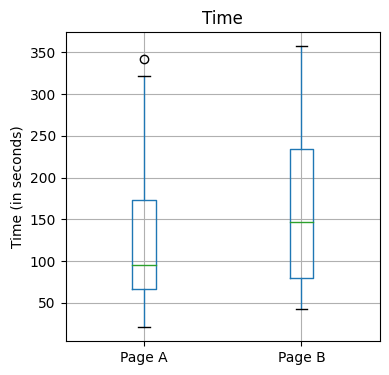

In [8]:
ax = session_times.boxplot(by="Page", column="Time", figsize=(4,4))
ax.set_xlabel("")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")
plt.tight_layout()
plt.show()

In [11]:
mean_a = session_times[session_times["Page"]=="Page A"]["Time"].mean()
mean_b = session_times[session_times["Page"]=="Page B"]["Time"].mean()
print(mean_b-mean_a)

35.66666666666667


In [19]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.iloc[list(idx_A)].mean()

nA = session_times[session_times["Page"]=="Page A"].shape[0]
nB = session_times[session_times["Page"]=="Page B"].shape[0]
print(perm_fun(session_times["Time"], nA, nB))

20.923809523809524


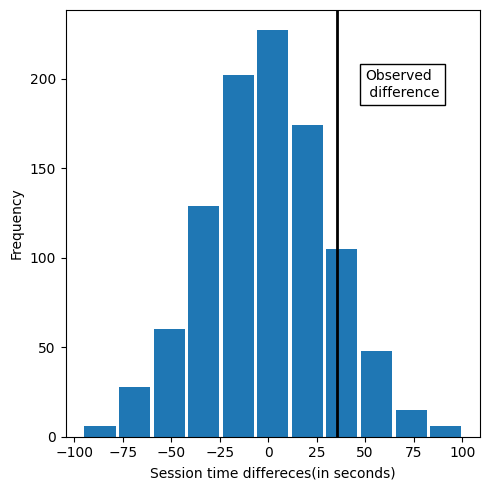

In [27]:
random.seed(1)
perm_diffs = [perm_fun(session_times["Time"], nA, nB) for _ in range(1000)]

fix, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b - mean_a, color="black", lw=2)
ax.text(50,190, "Observed\n difference", bbox={"facecolor":"white"}) 
ax.set_xlabel("Session time differeces(in seconds)")
ax.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

In [34]:
# convert perm_diffs to numpy array to avoid problems with some Python installations
perm_diffs = np.array(perm_diffs)
print(np.mean(perm_diffs > mean_b - mean_a))

0.0


# Statistical Significance and P-Values

Observed difference: 0.0368%


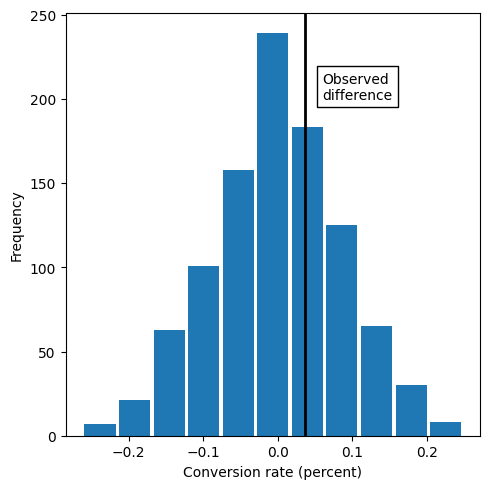

In [35]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## P-Value

In [36]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


In [37]:
survivors = np.array([[200, 23749-200],[182,22588-182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"P-value for single sided test: {p_value/2:.4f}")

P-value for single sided test: 0.3513


## t-Tests

In [38]:
res = stats.ttest_ind(session_times[session_times["Page"] == "Page A"].Time,
                      session_times[session_times["Page"] == "Page B"].Time,
                      equal_var=False)
print(f"P-value for single sided test: {res.pvalue / 2:.4f}")

P-value for single sided test: 0.1408


In [39]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times["Page"]=="Page A"].Time,
    session_times[session_times["Page"]=="Page B"].Time,
    usevar="unequal", alternative="smaller")
print(f"P-value: {pvalue:.4f}")

P-value: 0.1408


# ANOVA

In [43]:
four_sessions = pd.read_csv('four_sessions.csv')
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


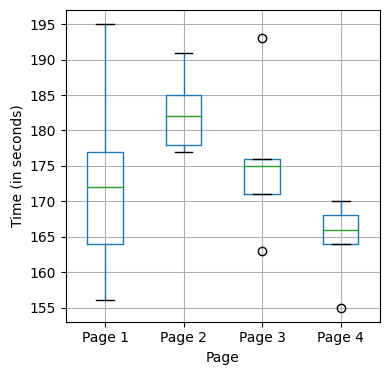

In [45]:
ax = four_sessions.boxplot(by="Page", 
                           column = "Time",
                           figsize=(4,4))
ax.set_xlabel("Page")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")
plt.title("")
plt.tight_layout()
plt.show()

In [55]:
observed_variance = four_sessions.groupby(["Page"]).mean().var()[0]
fsg = four_sessions.groupby("Page").mean().values.ravel()
print("Observed means:", fsg)
print('Variance:', observed_variance)

# Permutation test example with stickiness
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
16.920000000000044


Pr(Prob) 0.084


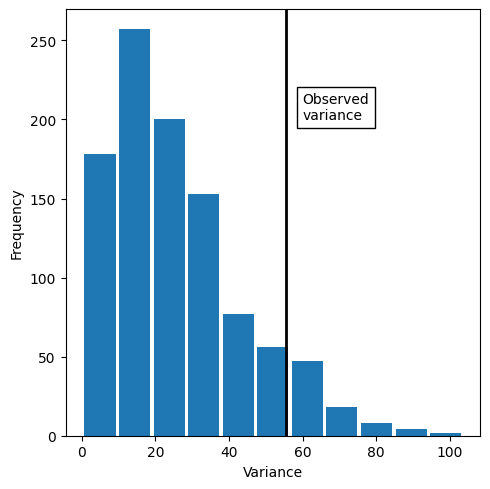

In [57]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(1000)]
npm = np.mean([var > observed_variance for var in perm_variance])
print("Pr(Prob)", npm)

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color="black", lw=2)
ax.text(60,200, "Observed\nvariance", bbox={"facecolor":"white"})
ax.set_xlabel("Variance")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## F-Statistic

In [58]:
model = smf.ols("Time ~ Page", data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


In [59]:
res = stats.f_oneway(
    four_sessions[four_sessions["Page"]=="Page 1"].Time,
    four_sessions[four_sessions["Page"]=="Page 2"].Time,
    four_sessions[four_sessions["Page"]=="Page 3"].Time,
    four_sessions[four_sessions["Page"]=="Page 4"].Time)
print(f"F-Statistic: {res.statistic /2:.4f}")
print(f"P-value: {res.pvalue /2:.4f}")

F-Statistic: 1.3699
P-value: 0.0388


# Chi-Square Test

In [65]:
click_rate = pd.read_csv('click_rates.csv')
clicks = click_rate.pivot(index="Click",columns="Headline", values="Rate")
clicks.head()

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [66]:
row_average = clicks.mean(axis=1)
pd.DataFrame({
    "Headline A": row_average,
    "Headline B": row_average,
    "Headline C": row_average})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [67]:
box = [1] * 34
box.extend([0]*2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe-expect)**2/expect
                                 for observe in row])
    
    return np.sum(pearson_residuals)

expected_clicks = 34/3
expected_noclicks = 1000-expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks=[1000-n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed)/len(perm_chi2)
print(f"Observed chi2: {chi2observed:.4f}")
print(f"Resampled p-value: {resampled_p_value:.4f}")

Observed chi2: 1.6659
Resampled p-value: 0.4660


In [69]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f"Observed chi2: {chisq:.4f}")
print(f"p-value: {pvalue:.4f}")

Observed chi2: 1.6659
p-value: 0.4348


In [73]:
expected = [expected_clicks, expected_noclicks]
def sample_with_replacement(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000-n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [sample_with_replacement(box) for _ in range(2000)]

resample_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f"Observed chi2: {chi2observed:.4f}")
print(f"Resample p-value: {resampled_p_value:.4f}")

Observed chi2: 1.6659
Resample p-value: 0.4660


## Figure chi-sq distribution

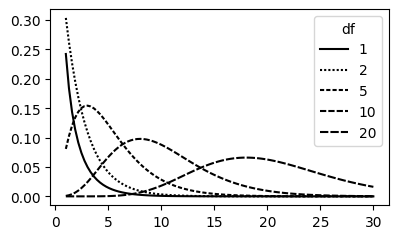

In [75]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

## Fisher's Exact Test

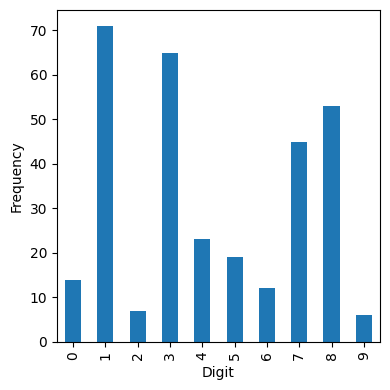

In [82]:
imanishi = pd.read_csv('imanishi_data.csv')
imanishi.columns = [c.strip() for c in imanishi.columns]
ax = imanishi.plot.bar(x="Digit",
                       y="Frequency",
                       legend=False,
                       figsize=(4,4))
ax.set_xlabel("Digit")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [80]:
imanishi.head()

,Digit,Frequency
0,0,14
1,1,71
2,2,7
3,3,65
4,4,23


# Power and Sample Size

In [88]:
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size = effect_size,
                              alpha=0.05,
                              power=0.8,
                              alternative="larger")
print("Sample Size: %.3f" % result)

Sample Size: 116602.393


In [89]:
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, 
                              power=0.8, 
                              alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
